In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [42]:
x = []
y = []
gesture_classes = []
filenames = ['one', 'two', 'three', 'four', 'undo']
npy_files = os.path.join("data", "*.npy")

for filename in filenames:
    npy_file = os.path.join("data", f"{filename}.npy")
    basename = os.path.basename(filename)
    gesture_class = basename.replace('.npy', '')
    
    data = np.load(npy_file)
    x.extend(data)
    y.extend([gesture_class] * len(data))
    
    if gesture_class not in gesture_classes:
        gesture_classes.append(gesture_class)

x = np.array(x)
y = np.array(y)

In [43]:
print(f"Feature dimension: {x.shape[1]}")  # 18
print(f"Gesture classes: {gesture_classes}")
print(f"Class distribution:")
unique, counts = np.unique(y, return_counts=True)
for class_name, count in zip(unique, counts):
    print(f"  {class_name}: {count} samples")

Feature dimension: 18
Gesture classes: ['one', 'two', 'three', 'four', 'undo']
Class distribution:
  four: 300 samples
  one: 300 samples
  three: 300 samples
  two: 300 samples
  undo: 300 samples


In [44]:
y_encoded = np.array([{label: i for i, label in enumerate(gesture_classes)}[label] for label in y])
num_classes = len(gesture_classes)
print("Original:", y)
print("Encoded: ", y_encoded)
indices = np.random.permutation(len(x))
x_shuffled = x[indices]
y_shuffled = y_encoded[indices]

Original: ['one' 'one' 'one' ... 'undo' 'undo' 'undo']
Encoded:  [0 0 0 ... 4 4 4]


In [45]:
mean_values = np.mean(x_shuffled, axis=0)
std_values = np.std(x_shuffled, axis=0)

# Save these parameters
np.save('normalization_mean5.npy', mean_values)
np.save('normalization_std5.npy', std_values)

# Apply normalization to training data
x_normalized = (x_shuffled - mean_values) / std_values

# Split data into train, validation, and test sets
x_train, x_temp, y_train, y_temp = train_test_split(
    x_normalized, y_shuffled, test_size=0.3, random_state=42, stratify=y_shuffled
)

x_val, x_test, y_val, y_test = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"normalized features: {x_normalized}")
print(f"Training samples: {len(x_train)}")
print(f"Validation samples: {len(x_val)}")
print(f"Test samples: {len(x_test)}")

normalized features: [[-0.81433528 -0.59592592  2.77879908 ... -0.08012351 -1.14270134
  -0.5904114 ]
 [-1.04661344 -0.69841141 -0.60988924 ... -1.40832015 -1.15212995
  -0.88826088]
 [-0.56577688 -0.29919542 -0.43881394 ...  0.33996426  1.52587311
  -0.67164616]
 ...
 [-0.06487682  4.1870368  -0.74922983 ...  0.96230889  0.59394948
   0.7226887 ]
 [ 0.0993024  -0.81355087 -0.54049303 ... -1.31599999 -1.15199724
  -0.78911959]
 [-0.56741881 -0.85406003 -0.67618486 ... -1.27540306 -1.12919675
  -0.89818188]]
Training samples: 1050
Validation samples: 225
Test samples: 225


In [50]:
model = models.Sequential([
    # Input layer
    tf.keras.Input(shape=(18, 1)),
    
    # First convolutional block
    layers.Conv1D(32, kernel_size=3, activation='relu', padding='same'),
    
    # Second convolutional block
    layers.Conv1D(64, kernel_size=3, activation='relu', padding='same'),
    
    # Global max pooling
    layers.GlobalMaxPool1D(),
    # Dense layers
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.3),

    # Output layer
    layers.Dense(num_classes, activation='softmax')
])

In [51]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Display model architecture
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_14 (Conv1D)              │ (None, 18, 32)         │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 18, 64)         │         6,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_7          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,821 (42.27 KB)

 Trainable params: 10,821 (42.27 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=7,
        restore_best_weights=True,
        verbose=1
    ),
    # ModelCheckpoint(
    #     'best_gesture_model.h5',
    #     monitor='val_accuracy',
    #     save_best_only=True,
    #     verbose=1
    # )
]

In [53]:
# Train the model
history = model.fit(
    x_train, y_train,
    batch_size=32,
    epochs=26,
    validation_data=(x_val, y_val),
    callbacks=callbacks,
    verbose=1
)

Epoch 1/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2992 - loss: 1.5456 - val_accuracy: 0.5378 - val_loss: 1.3629
Epoch 2/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5331 - loss: 1.2899 - val_accuracy: 0.6089 - val_loss: 1.0483
Epoch 3/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6670 - loss: 0.9826 - val_accuracy: 0.7867 - val_loss: 0.7543
Epoch 4/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7908 - loss: 0.7185 - val_accuracy: 0.8933 - val_loss: 0.5339
Epoch 5/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8810 - loss: 0.4852 - val_accuracy: 0.9156 - val_loss: 0.3869
Epoch 6/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9159 - loss: 0.3594 - val_accuracy: 0.9067 - val_loss: 0.3456
Epoch 7/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9247 - loss: 0.2766 - val_accuracy: 0.9422 - val_loss: 0.2632
Epoch 8/26
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9396 - loss: 0.2292 - val_accuracy: 0.9511 - val_l

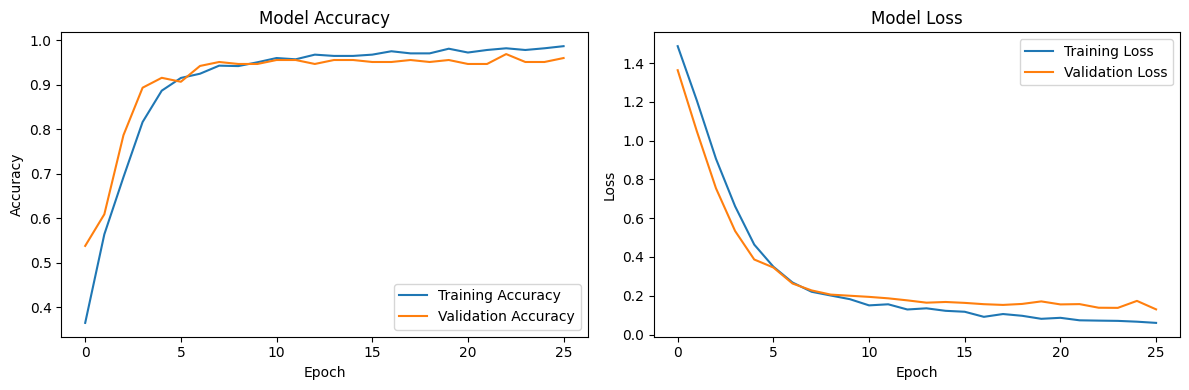

In [54]:
# Plot training history
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training & validation accuracy
ax1.plot(history.history['accuracy'], label='Training Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy')
ax1.legend()

# Plot training & validation loss
ax2.plot(history.history['loss'], label='Training Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()

plt.tight_layout()
plt.show()

Test Accuracy: 0.9867
Test Loss: 0.0499
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step

Classification Report:
              precision    recall  f1-score   support

         one       0.96      1.00      0.98        45
         two       0.98      0.98      0.98        45
       three       1.00      0.98      0.99        45
        four       1.00      1.00      1.00        45
        undo       1.00      0.98      0.99        45

    accuracy                           0.99       225
   macro avg       0.99      0.99      0.99       225
weighted avg       0.99      0.99      0.99       225



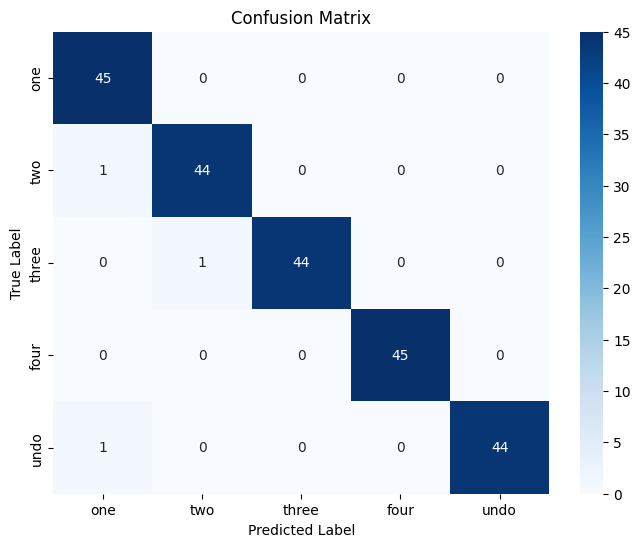

In [55]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Make predictions
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, 
                          target_names=gesture_classes))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=gesture_classes,
            yticklabels=gesture_classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [56]:
# Save the trained model
model.save('gesture_quiz5.h5')